In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.special import iv
from scipy.optimize import curve_fit

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

subjects = [114, 115, 127, 135, 136, 139, 141, 142]
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']

task_cmap = {
    'perception': 'darkblue',
    'wm': 'green',
    'ltm': 'orange'
}
roi_label_loc = {roi:rois.index(roi) for roi in rois}

scatter_dot_size = 4
fig_height = 5
fig_width = 5

rois = ["V1", 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']
metrics = ['loc_deg', 'amp', 'fwhm']
metrics = ['loc_deg', 'amp', 'fwhm']
plt.style.use('seaborn-v0_8')

deriv_dir = os.path.expanduser("../derivatives/")

dataframe_dir = os.path.join(deriv_dir, "dataframes")


In [2]:
def vonmises(theta, loc, kappa, scale):
    p = scale * np.exp(kappa*np.cos(theta-loc))/(2*np.pi*iv(0,kappa))
    return p


def diff_vonmises(theta, loc, kappa1, scale1, kappa2, scale2):
    p1 = vonmises(theta, loc, kappa1, scale1)
    p2 = vonmises(theta, loc, kappa2, scale2)
    return (p1 - p2) 

# Figure 4b

In [3]:

fname = os.path.join(dataframe_dir, "glmsingle", "allsubj_vmfits_ang_dist_bin.tsv")
vmfits = pd.read_csv(fname, sep = '\t', index_col = 0)

rois = ["V1", 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
vmfits['roi_labels'] = pd.Categorical(vmfits['roi_labels'], categories = rois , ordered = True)

In [4]:


path_pattern = os.path.join(dataframe_dir, "glmsingle/bootstrap_vmfits/allsubj_vmfits_ang_dist_bin_batch_%d.tsv")

rois = ["V1", 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']
metrics = ['loc_deg', 'amp', 'fwhm']

df = []
for i in range(1, 21):
    fname = path_pattern % i
    data = pd.read_csv(fname, sep = '\t', index_col = 0)
    data.insert(0, 'batch_num', i)
    df.append(data)
    
df = pd.concat(df)

data_df = []
for roi, task, metric in itertools.product(rois, tasks, metrics + ["loc"]):
    data = df.query("task == @task & roi_labels == @roi")

    CIs = np.quantile(data[metric], [0.16, 0.84, 0.025, 0.975])
    metric_val = vmfits.query("task == @task & roi_labels == @roi")[metric].values[0]

    row = [roi, task, metric, metric_val, *CIs]
    data_df.append(row)

data_df = pd.DataFrame(data_df, columns = ['roi_labels', "task", "metric", "value", "lower_68_CI", "upper_68_CI", "lower_95_CI", "upper_95_CI"])

data_df['roi_labels'] = pd.Categorical(data_df['roi_labels'], categories = rois , ordered = True)
data_df['task_color'] = [str(task_cmap[t]) for t in data_df.task]




/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49045/3469202163.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rois)
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49045/3469202163.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rois)
/var/folders/2h/28f74q2d14b9k1nvsyvnn064_091rw/T/ipykernel_49045/3469202163.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rois)


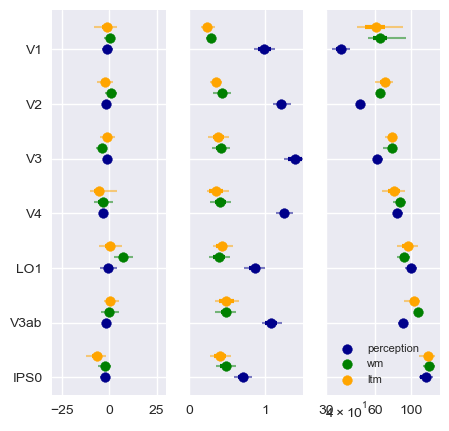

In [5]:
metrics = ['loc_deg', 'amp', 'fwhm']
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(1, 3, sharey = True, figsize = [fig_width, fig_height])

for metric, task  in itertools.product(metrics, tasks):
    ax = axs[metrics.index(metric)]

    lgnd=False

    match metric:
        case 'loc_deg':
            ax.set_xlim([-30, 30])
        case 'amp':
            ax.set_xlim([0, 1.5])
            
        case 'fwhm':
            ax.set_xscale('log')
            ax.set_xlim([30, 150])

    offset = tasks.index(task) * .2

    data = data_df.query("metric == @metric & task == @task")
    err_center = (data.lower_68_CI + data.upper_68_CI) / 2
    x_95 = [err_center - data.lower_95_CI, data.upper_95_CI - err_center]
    x_68 = [err_center - data.lower_68_CI, data.upper_68_CI - err_center]

    y = [rois.index(label)+1 - offset for label in data.roi_labels]
    
    ax.errorbar(x = data.value, y = y, fmt = "", xerr = x_95, color = task_cmap[task], alpha = 0.5, elinewidth = 1.5, ls='none')
    ax.errorbar(x = data.value, y = y, fmt = "", xerr = x_68, color = task_cmap[task], alpha = 1, elinewidth = 3, ls = 'none')
    ax.scatter(x = data.value, y = y, color = task_cmap[task])

    ax.set_yticks(range(1, 8), rois)
    if metric == 'fwhm':
        ax.set_xticklabels(rois)
        ax.set_xticks([30, 60, 100], [30, 60, 100])

    ax.invert_yaxis()

for task in tasks:
    ax.scatter([], [], label = task, color = task_cmap[task])

ax.legend(fontsize = 8, loc = 'lower left', markerscale = 1)

# Figure 4a

In [6]:
fname = os.path.join(dataframe_dir, "glmsingle", "allsubj_dist_normedbetas_ang_dist_bin.tsv")
norm_data = pd.read_csv(fname, sep = '\t', index_col = 0)

In [7]:
# Get fits and structure data
theta_range = np.linspace(-np.pi, np.pi, 361)

# The labels of each ROI 
roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]

# The order we want to plot the ROIs in
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

# Assign a new column containing the roi labels to the data fits and bootstrap fits
# data_df['roi_labels'] = [roi_labels[int(l-1)] for l in data_df.roi.values]
# df['roi_labels'] = [roi_labels[int(l-1)] for l in df.roi.values]

# Define confidence interval for bootstraps
conf_interval = [16, 84]

# Error bands 
EB = {}

# Von Mises 
VMS = {}

# For each roi x condition, generate the von mises curve and its confidence interval
for i, row in vmfits.iterrows():

    # Subset data
    vm = diff_vonmises(theta_range, row['loc'], row.kappa1, row.scale1, row.kappa2, row.scale2)

    # Get bootstrap intervals
    bfits = []
    b = df.query('task == @row.task & roi_labels == @row.roi_labels').filter(['roi_labels', 'task', 'loc', 'kappa1', 'scale1', 'kappa2', 'scale2'])
    for j, brow in b.iterrows():
        roi, task, l, k, s, k2, s2 = brow
        yhat = diff_vonmises(theta_range, l, k, s, k2, s2)
        bfits.append(yhat)
    bfits=np.vstack(bfits)
    err_bands = np.nanpercentile(bfits, conf_interval, axis=0)

    key = "%s_%s" % (row.roi_labels, row.task)
    EB[key] = err_bands
    VMS[key] = vm

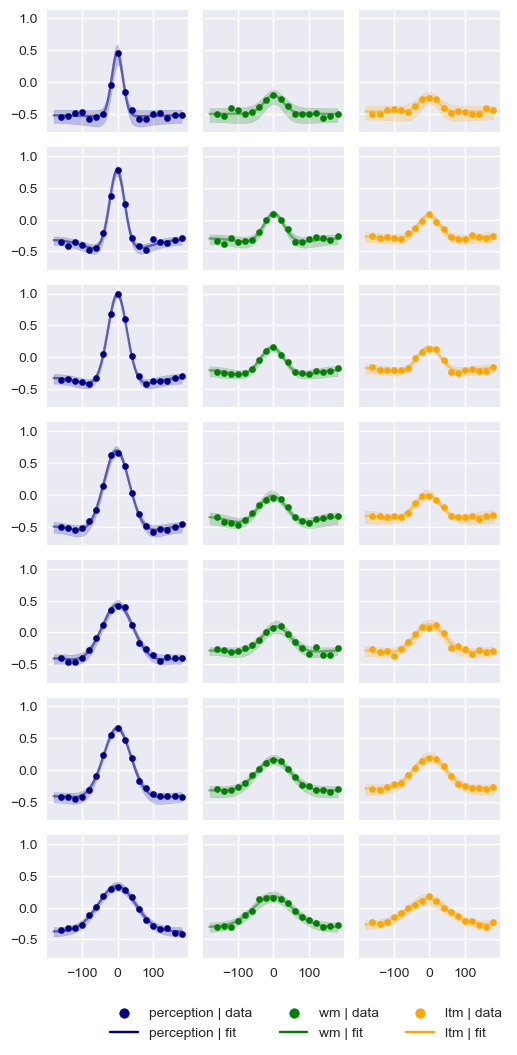

In [8]:
fig, axs = plt.subplots(7, 3, figsize = [fig_width, fig_height*2], sharex = True, sharey = True)

for roi, task in itertools.product(rois, tasks):
    y = VMS['%s_%s' % (roi, task)]
    err_bands = EB['%s_%s' % (roi, task)]
    r, c = rois.index(roi), tasks.index(task)

    ax = axs[r, c]

    ndata = norm_data.query("roi_labels == @roi & task == @task")
    ax.fill_between(x = np.degrees(theta_range),  y1 = err_bands[1, :], y2 = err_bands[0, :], color = task_cmap[task], alpha = 0.2)
    ax.scatter(x = ndata.ang_dist_bin, y = ndata.beta_adj_perc, s = 20, color = task_cmap[task])
    ax.plot(np.degrees(theta_range), y, color = task_cmap[task], alpha = 0.5)


# g.set_titles("{col_name}")

for task in tasks:
    plt.scatter([], [], label = "%s | %s" % (task, "data"), color = task_cmap[task])
    plt.plot([], label = "%s | %s" % (task, "fit"), color = task_cmap[task])


# plt.gcf().set_size_inches([fig_width*2, fig_height])
plt.gcf().legend(loc = 'upper right', bbox_to_anchor = (1, 0), bbox_transform = plt.gcf().transFigure, ncol = 3)

plt.gcf().tight_layout()